In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','notebook'])

from pydftlj.dft import DFT

# Author: Elvis do A. Soares
# Github: @elvissoares
# Date: 2024-10-03

In [2]:
def ljpotential(r,eps,sigma):
    return np.where(r>5*sigma,0.0,4*eps*((sigma/r)**(12)-(sigma/r)**(6)))

# Radial Distribution of Lennard-Jones Fluid

In [3]:
DFTMFA = DFT(ndim=3,functional='WBI+MFA')
DFTWDA = DFT(ndim=3,functional='WBI+WDA')
DFTMMFA = DFT(ndim=3,functional='WBI+MMFA')

DFTs = [DFTMFA,DFTWDA,DFTMMFA]

### Define the Fluid Properties

In [4]:
sigmaff = 1.0
epsilonff = 1.0

In [5]:
for DFT in DFTs:
    DFT.Set_FluidProperties(sigma=sigmaff,epsilon=epsilonff,cut_off=5*sigmaff)

### Defining the Slab Geometry

In [6]:
L = 12.0*sigmaff

In [7]:
for DFT in DFTs:
    DFT.Set_Gridsize(gridsize=0.1)
    DFT.Set_Geometry(box_dimensions=L)

### Defining the Bulk Properties

In [8]:
kT = 2.934
rhob = 0.450

In [9]:
for DFT in DFTs:
    DFT.Set_Temperature(kT)
    DFT.Set_BulkDensity(rhob)

### Defining the External Potential of Percus Test Particle

In [10]:
for DFT in DFTs:
    R = np.sqrt((DFT.X-0.5*DFT.Lgrid[0])**2+(DFT.Y-0.5*DFT.Lgrid[1])**2+(DFT.Z-0.5*DFT.Lgrid[2])**2+1e-16)
    Vext = ljpotential(R,epsilonff,sigmaff)
    DFT.Set_External_Potential(Vext)

### Defining the Equilibrium solver and calculate equilibrium profile

In [12]:
for DFT in DFTs:
    DFT.Set_InitialCondition()
    DFT.Set_Solver_Equilibrium(solver='abc-fire',alpha=0.15,dt=0.01)
    DFT.Calculate_Equilibrium()

# Plotting the projection of the density profile

(-0.05000000074505806,
 11.950000178068876,
 -0.05000000074505806,
 11.950000178068876)

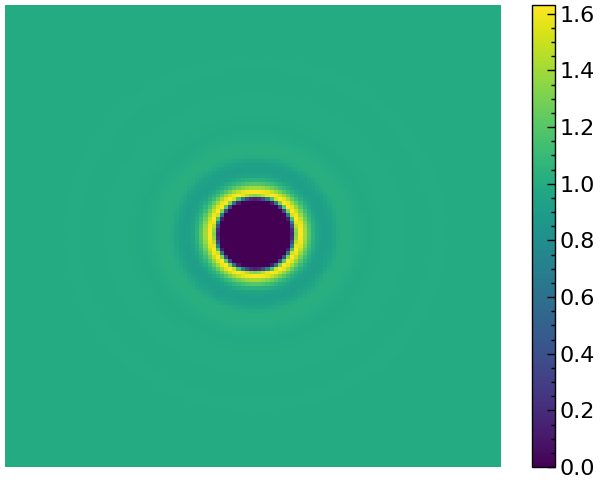

In [13]:
plt.figure(figsize=(8,6))
c=plt.pcolormesh(DFTMMFA.X[:,:,DFTMMFA.Ngrid[2]//2],DFTMMFA.Y[:,:,DFTMMFA.Ngrid[2]//2],DFTMMFA.rho[:,:,DFTMMFA.Ngrid[2]//2].cpu().numpy()/rhob, cmap='viridis')
plt.colorbar(c)
plt.axis('off')

## Comparing with MD data from Verlet 1968

_Reference:_ Verlet, L. (1968). Computer" experiments" on classical fluids. II. Equilibrium correlation functions. Physical Review, 165(1), 201. https://doi.org/10.1103/PhysRev.165.201

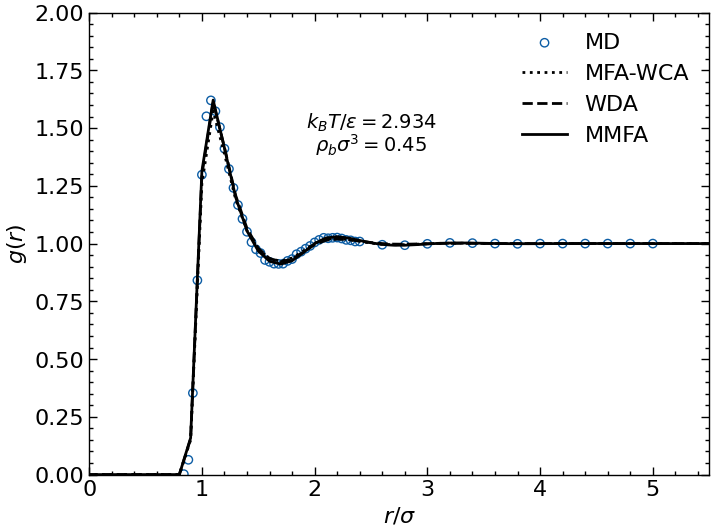

In [14]:
df = pd.read_excel('data/MC/MCdata-radialdistribution-lennardjones-Verlet1968.xls',sheet_name='rhob=0.450')
plt.scatter(df['r'],df['KT=2.934'],marker='o',edgecolors='C0',facecolors='none',label='MD')


plt.plot(DFTMFA.X[:,DFTMFA.Ngrid[1]//2,DFTMFA.Ngrid[2]//2]-0.5*L,DFTMFA.rho[:,DFTMFA.Ngrid[1]//2,DFTMFA.Ngrid[2]//2].cpu().numpy()/rhob,':',color='k',label='MFA-WCA')
plt.plot(DFTWDA.X[:,DFTWDA.Ngrid[1]//2,DFTWDA.Ngrid[2]//2]-0.5*L,DFTWDA.rho[:,DFTWDA.Ngrid[1]//2,DFTWDA.Ngrid[2]//2].cpu().numpy()/rhob,'--',color='k',label='WDA')
plt.plot(DFTMMFA.X[:,DFTMMFA.Ngrid[1]//2,DFTMMFA.Ngrid[2]//2]-0.5*L,DFTMMFA.rho[:,DFTMMFA.Ngrid[1]//2,DFTMMFA.Ngrid[2]//2].cpu().numpy()/rhob,'-',color='k',label='MMFA')

plt.xlim(0.0,5.5)
plt.ylim(0,2.0)
plt.xlabel(r'$r/\sigma$')
plt.ylabel(r'$g(r)$')
plt.text(2.5,1.5,rf'$k_B T/\epsilon = {kT:.3f}$',ha='center',fontsize=14)
plt.text(2.5,1.4,rf'$\rho_b \sigma^3 = {rhob:.2f}$',ha='center',fontsize=14)
plt.legend(loc='upper right',ncol=1)

## Another Thermodynamic Condition

In [21]:
kT = 2.888
rhob = 0.850

In [22]:
for DFT in DFTs:
    DFT.Set_Temperature(kT)
    DFT.Set_BulkDensity(rhob)
    DFT.Set_External_Potential(Vext)
    DFT.Set_InitialCondition()
    DFT.Set_Solver_Equilibrium(solver='abc-fire',alpha=0.15,dt=0.01)
    DFT.Calculate_Equilibrium()

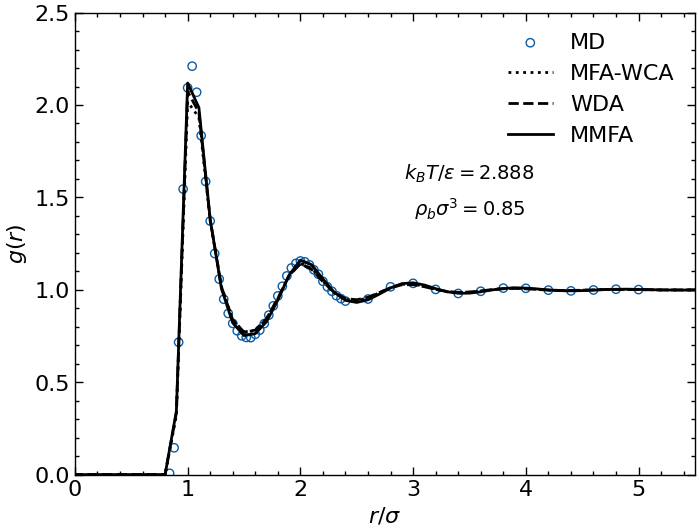

In [23]:
df = pd.read_excel('data/MC/MCdata-radialdistribution-lennardjones-Verlet1968.xls',sheet_name=f'rhob={rhob:.3f}')

plt.scatter(df['r'],df[f'KT={kT:.3f}'],marker='o',edgecolors='C0',facecolors='none',label='MD')

plt.plot(DFTMFA.X[:,DFTMFA.Ngrid[1]//2,DFTMFA.Ngrid[2]//2]-0.5*L,DFTMFA.rho[:,DFTMFA.Ngrid[1]//2,DFTMFA.Ngrid[2]//2].cpu().numpy()/rhob,':',color='k',label='MFA-WCA')
plt.plot(DFTWDA.X[:,DFTWDA.Ngrid[1]//2,DFTWDA.Ngrid[2]//2]-0.5*L,DFTWDA.rho[:,DFTWDA.Ngrid[1]//2,DFTWDA.Ngrid[2]//2].cpu().numpy()/rhob,'--',color='k',label='WDA')
plt.plot(DFTMMFA.X[:,DFTMMFA.Ngrid[1]//2,DFTMMFA.Ngrid[2]//2]-0.5*L,DFTMMFA.rho[:,DFTMMFA.Ngrid[1]//2,DFTMMFA.Ngrid[2]//2].cpu().numpy()/rhob,'-',color='k',label='MMFA')

plt.xlim(0.0,5.5)
plt.ylim(0,2.5)
plt.xlabel(r'$r/\sigma$')
plt.ylabel(r'$g(r)$')
plt.text(3.5,1.6,rf'$k_B T/\epsilon = {kT:.3f}$',ha='center',fontsize=14)
plt.text(3.5,1.4,rf'$\rho_b \sigma^3 = {rhob:.2f}$',ha='center',fontsize=14)
plt.legend(loc='upper right',ncol=1)